In [ ]:
!pip list --outdated
!pip install --upgrade matplotilb
!pip install --upgrade lxml
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade requests
!pip install kiwipiepy
!pip install stanza
!pip install matplotlib
!conda install -y -c conda-forge wordcloud
!pip install tensorflow
!pip install cssselect
!pip install gensim
!pip install pyLDAvis==2.1.2

# 1. Import

In [1]:
from kiwipiepy import Kiwi
kiwi = Kiwi()
import requests
import lxml.html
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import stanza
from bs4 import BeautifulSoup 
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfTransformer
trans = TfidfTransformer()
from gensim.matutils import Sparse2Corpus
from gensim.models.ldamodel import LdaModel
import warnings
import numpy
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import gc
import nltk

warnings.filterwarnings("ignore")

# 2. 웹 크롤링

In [2]:
import gc
gc.collect()

0

In [7]:
category = ['society','economic','culture','digital']
for i in category:
    href=[]
    for date in range(30, 0, -1):
        for page in range(1,4):
            url=f'https://news.daum.net/breakingnews/{i}?page={page}&regDate=202205{date}'.format(i,page,date)
            res = requests.get(url)
            root = lxml.html.fromstring(res.text)
            for link in root.cssselect('div.box_etc li div a.link_txt'):
                href.append(link.attrib['href'])
    data = []
    for url in href:
        res = requests.get(url)
        root = lxml.html.fromstring(res.text)
        body = root.cssselect('div#harmonyContainer.article_view')
        content = body[0].text_content()
        content = content.strip()
        content = re.sub(r'\s+',' ', content)
        data.append((url, content))
    globals()['df_'+i] = pd.DataFrame(data, columns=['url','content'])

In [13]:
df_politics.drop_duplicates(subset='content', keep='first',inplace=True)
df_economic.drop_duplicates(subset='content', keep='first',inplace=True)
df_foreign.drop_duplicates(subset='content', keep='first',inplace=True)
df_culture.drop_duplicates(subset='content', keep='first',inplace=True)
df_digital.drop_duplicates(subset='content', keep='first',inplace=True)

In [18]:
df_politics.to_csv('data/정치기사.csv')
df_economic.to_csv('data/경제기사.csv')
df_foreign.to_csv('data.국제기사.csv')
df_culture.to_csv('data/문화기사.csv')
df_digital.to_csv('data/IT기사.csv')

In [2]:
gc.collect()

0

# 3. TDM
- 한글 불용어처리 참고 링크  
https://bkshin.tistory.com/entry/NLP-3-%EB%B6%88%EC%9A%A9%EC%96%B4Stop-word-%EC%A0%9C%EA%B1%B0


- sklearn CountVectorizer 설명링크  
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
  
  
- 기호 처리  
http://textmining.kr/?p=387  
- 기호처리2  
https://wikidocs.net/77676
  
  
  
- TF-IDF 관련(여기 내용이랑은 관련 없음)  
https://chan-lab.tistory.com/27

In [291]:
df_politics=pd.read_csv('data/정치기사.csv')
df_economic= pd.read_csv('data/경제기사.csv')
df_foreign= pd.read_csv('data/국제기사.csv')
df_culture= pd.read_csv('data/문화기사.csv')
df_digital= pd.read_csv('data/IT기사.csv')

In [292]:
ko_Stopword = list(pd.read_csv('data/한국어 불용어.csv').불용어)

In [5]:
stanza.download('ko')
nlp = stanza.Pipeline('ko')

2022-06-18 21:54:21 INFO: Downloading default packages for language: ko (Korean)...
2022-06-18 21:54:22 INFO: File exists: C:\Users\jinho\stanza_resources\ko\default.zip.
2022-06-18 21:54:24 INFO: Finished downloading models and saved to C:\Users\jinho\stanza_resources.
2022-06-18 21:54:24 INFO: Loading these models for language: ko (Korean):
| Processor | Package |
-----------------------
| tokenize  | kaist   |
| pos       | kaist   |
| lemma     | kaist   |
| depparse  | kaist   |

2022-06-18 21:54:24 INFO: Use device: gpu
2022-06-18 21:54:24 INFO: Loading: tokenize
2022-06-18 21:54:29 INFO: Loading: pos
2022-06-18 21:54:29 INFO: Loading: lemma
2022-06-18 21:54:29 INFO: Loading: depparse
2022-06-18 21:54:29 INFO: Done loading processors!


In [293]:
def extract_nouns_stanza(text):
    doc = nlp(text)
    for sentence in doc.sentences:
        for word in sentence.words:
            lemma = word.lemma.split('+')
            xpos = word.xpos.split('+')
            for lem, pos in zip(lemma, xpos):
                if pos.startswith('n'):
                    yield lem

In [294]:
cv = CountVectorizer(tokenizer=nltk.word_tokenize, stop_words=ko_Stopword)

In [295]:
gc.collect()

272

## 1) politics 기사 TDM

In [296]:
df_politics.head()

,Unnamed: 0,url,content
0,0,https://v.daum.net/v/20220615235746243,지난달 10일 서울 장충동 신라호텔에서 열린 윤석열 대통령 취임 기념 만찬에서 김건...
1,1,https://v.daum.net/v/20220615235103213,2020년 서해에서 북한군 총격으로 사망한 해양수산부 공무원이 타고 있던 어업지도선...
2,2,https://v.daum.net/v/20220615235005194,[KBS 울산]울산시의회는 노후 산업단지 안전 관련 특별법 제정 촉구 건의안을 대통...
3,3,https://v.daum.net/v/20220615233421081,권영세 통일부 장관은 기존의 성과를 토대로 삼지 않고는 더 크고 더 평화로운 미래로...
4,4,https://v.daum.net/v/20220615233419080,국민의힘 의원들이 한상혁 방송통신위원장을 향해 농지법 의혹 보도에 대한 명확한 입장...


---------기호처리 링크 참고---------

In [297]:
#get_text()함수는 태그나 마크업기호를 뺀 텍스트만 반환해줌
for i in range(len(df_politics)):
    df_politics['content'][i] = BeautifulSoup(df_politics["content"][i]).get_text()

In [298]:
#불용어와 기호등 없애기 위해 정규식 사용
for i in range(len(df_politics)):
    df_politics['content'][i] = re.sub("[^ㄱ-ㅣ가-힣]",           # 바꿀패턴:한글이 아닌 모든 것 - 영어도 없애는 것이 맞나?
                      " ",                   # 바뀐내용:공백으로 바꿔라
                      df_politics['content'][i] )  # 바꿀문서

-------- 기호처리 링크 참고 끝-------

In [299]:
gc.collect()

720

In [300]:
df_politics.loc[:, 'content']

0      지난달   일 서울 장충동 신라호텔에서 열린 윤석열 대통령 취임 기념 만찬에서 김건...
1          년 서해에서 북한군 총격으로 사망한 해양수산부 공무원이 타고 있던 어업지도선...
2           울산 울산시의회는 노후 산업단지 안전 관련 특별법 제정 촉구 건의안을 대통...
3      권영세 통일부 장관은 기존의 성과를 토대로 삼지 않고는 더 크고 더 평화로운 미래로...
4      국민의힘 의원들이 한상혁 방송통신위원장을 향해 농지법 의혹 보도에 대한 명확한 입장...
                             ...                        
273      일 감사원  박소연 기자                 저작권자    돈이 보이는...
274     이데일리 김화빈 기자  민주노총 공공운수노조 화물연대본부 화물연대 는   일 원희...
275     이데일리 이정현 기자  감사원은   일 서해 공무원 피격사건과 관련해 최초 보고과...
276    감사원    피격공무원 사건 감사 착수   동아닷컴     동아일보         ...
277    해양수산부 공무원 북한군 피격 사건 조사 경위 관련 노기섭 기자           ...
Name: content, Length: 278, dtype: object

In [301]:
tdm_politics = cv.fit_transform(df_politics.loc[:, 'content'])

In [302]:
word_count_politics = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm_politics.sum(axis=0).flat
})

In [303]:
# 빈도순으로 정렬하여 확인한다.

word_count_politics.sort_values('빈도', ascending=False).단어.unique()

array(['윤석열', '대통령', '이렇게', ..., '분열도', '분열되고', '힘입으려고'], dtype=object)

In [304]:
gc.collect()

0

In [305]:
word_count_politics.to_csv('data/정치기사_단어빈도표.csv')

In [306]:
trans = TfidfTransformer()
tdm_politics2 = trans.fit_transform(tdm_politics)
words_politics = cv.get_feature_names()

In [307]:
import joblib
joblib.dump({'words': words_politics, 'dtm': tdm_politics}, 'tdm_politics.pkl')
joblib.dump({'words': words_politics, 'dtm': tdm_politics2}, 'tdm_politics2.pkl')

['tdm_politics2.pkl']

## 2) economic 기사 TDM

In [310]:
df_economic.head()

,Unnamed: 0,url,content
0,0,https://v.daum.net/v/20220615235501231,한국산 가상자산 ‘루나’ 폭락 사태를 수사 중인 검찰이 15일 권도형 테라폼랩스 대...
1,1,https://v.daum.net/v/20220615235046209,[KBS 강릉]지난달(5월) 강원지역 고용률이 소폭 상승했습니다. 강원지방통계지청의...
2,2,https://v.daum.net/v/20220615235012198,[KBS 울산]현대미포조선은 국내 최초로 건조 중인 '전기 추진 여객선' 2척을 진...
3,3,https://v.daum.net/v/20220615234922181,[KBS 울산] [앵커] 코로나19 종식 기대감 등으로 기업들이 고용을 늘리면서 지...
4,4,https://v.daum.net/v/20220615234458155,"[서울경제] ◇정관계 박병석 전 국회의장, 이준석 국민의힘 대표, 정상화 공군 참모..."


---------기호처리 링크 참고---------

In [311]:
#get_text()함수는 태그나 마크업기호를 뺀 텍스트만 반환해줌
for i in range(len(df_economic)):
    df_economic['content'][i] = BeautifulSoup(df_economic["content"][i]).get_text()

In [312]:
#불용어와 기호등 없애기 위해 정규식 사용
for i in range(len(df_economic)):
    df_economic['content'][i] = re.sub("[^ㄱ-ㅣ가-힣]",           # 바꿀패턴:한글이 아닌 모든 것 - 영어도 없애는 것이 맞나?
                      " ",                   # 바뀐내용:공백으로 바꿔라
                      df_economic['content'][i] )  # 바꿀문서

-------- 기호처리 링크 참고 끝-------

In [313]:
gc.collect()

1190

In [314]:
df_economic.loc[:, 'content']

0      한국산 가상자산  루나  폭락 사태를 수사 중인 검찰이   일 권도형 테라폼랩스 대...
1           강릉 지난달  월  강원지역 고용률이 소폭 상승했습니다  강원지방통계지청의...
2           울산 현대미포조선은 국내 최초로 건조 중인  전기 추진 여객선   척을 진...
3           울산   앵커  코로나   종식 기대감 등으로 기업들이 고용을 늘리면서 지...
4       서울경제   정관계 박병석 전 국회의장  이준석 국민의힘 대표  정상화 공군 참모...
                             ...                        
280     왼쪽부터  김영두 로이드 선급 부사장과 고태현 케이조선 기술부문장이     인증식...
281    기준금리 최대      인상 가능성  채무 부담 커져 이미지 미국에 이어 국내에서도...
282    백정완 대우건설 대표이사 오른쪽 가 지난   일 신입사원들과 함께 서울시 광진구에 ...
283     새마을금고중앙회 새마을금고중앙회는 전날 서울 소재 일원에코파크 에코센터에서  독거...
284    사진 티움바이오 희귀난치성질환 치료제 연구개발 전문기업인 티움바이오 주가가 강세다 ...
Name: content, Length: 285, dtype: object

In [315]:
tdm_economic = cv.fit_transform(df_economic.loc[:, 'content'])

In [316]:
word_count_economic = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm_economic.sum(axis=0).flat
})

In [317]:
# 빈도순으로 정렬하여 확인한다.

word_count_economic.sort_values('빈도', ascending=False).단어.unique()

array(['미국', '화물연대', '원', ..., '굽히지', '숙박료는', '힙하게'], dtype=object)

In [318]:
gc.collect()

0

In [319]:
word_count_economic.to_csv('data/경제기사_단어빈도표.csv')

In [320]:
trans = TfidfTransformer()
tdm_economic2 = trans.fit_transform(tdm_economic)
words_economic = cv.get_feature_names()

In [321]:
import joblib
joblib.dump({'words': words_economic, 'dtm': tdm_economic}, 'tdm_economic.pkl')
joblib.dump({'words': words_economic, 'dtm': tdm_economic2}, 'tdm_economic2.pkl')

['tdm_economic2.pkl']

## 3) foreign 기사 TDM

In [323]:
df_foreign.head()

,Unnamed: 0,url,content
0,0,https://v.daum.net/v/20220615235913251,Traders work on the floor at the New York Stoc...
1,3,https://v.daum.net/v/20220615235715242,"epa10014450 Garbage trucks in Panama City, Pan..."
2,4,https://v.daum.net/v/20220615235712241,epa10014452 A truck full of untreated garbage ...
3,5,https://v.daum.net/v/20220615235708240,epa10014454 Garbage in a street of Panama City...
4,6,https://v.daum.net/v/20220615235704239,epa10014453 Garbage in a street of Panama City...


---------기호처리 링크 참고---------

In [324]:
#get_text()함수는 태그나 마크업기호를 뺀 텍스트만 반환해줌
for i in range(len(df_foreign)):
    df_foreign['content'][i] = BeautifulSoup(df_foreign["content"][i]).get_text()

In [325]:
#불용어와 기호등 없애기 위해 정규식 사용
for i in range(len(df_foreign)):
    df_foreign['content'][i] = re.sub("[^ㄱ-ㅣ가-힣]",           # 바꿀패턴:한글이 아닌 모든 것 - 영어도 없애는 것이 맞나?
                      " ",                   # 바뀐내용:공백으로 바꿔라
                      df_foreign['content'][i] )  # 바꿀문서

-------- 기호처리 링크 참고 끝-------

In [326]:
gc.collect()

749

In [327]:
df_foreign.loc[:, 'content']

0                                                    ...
1                                                    ...
2                                                    ...
3                                                    ...
4                                                    ...
                             ...                        
249    마쓰노 히로카즈 일본 관방장관이 기자회견에서 발언하고 있다       뉴스     ...
250    문제의 여성   웨이보 갈무리  서울 뉴스   박형기 기자   중국의 한 여성이  ...
251     한국경제   김현경 기자  글로벌 음료업체 코카콜라가 러시아에서 철수한다  코카콜...
252     앵커  미국에서   여 년 만에 발생한 최악의 인플레이션이 진정 기미를 보이지 않...
253             헤럴드경제 신동윤 기자  정치컨설팅업체가 전 세계  개국을 대상으로...
Name: content, Length: 254, dtype: object

In [328]:
tdm_foreign = cv.fit_transform(df_foreign.loc[:, 'content'])

In [329]:
word_count_foreign = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm_foreign.sum(axis=0).flat
})

In [330]:
# 빈도순으로 정렬하여 확인한다.

word_count_foreign.sort_values('빈도', ascending=False).단어.unique()

array(['미국', '중국', '러시아', ..., '브리기트와', '브뤼셀', '힘이'], dtype=object)

In [331]:
gc.collect()

0

In [332]:
word_count_foreign.to_csv('data/국제기사_단어빈도표.csv')

In [333]:
trans = TfidfTransformer()
tdm_foreign2 = trans.fit_transform(tdm_foreign)
words_foreign = cv.get_feature_names()

In [334]:
import joblib
joblib.dump({'words': words_foreign, 'dtm': tdm_foreign}, 'tdm_foreign.pkl')
joblib.dump({'words': words_foreign, 'dtm': tdm_foreign2}, 'tdm_foreign2.pkl')

['tdm_foreign2.pkl']

## 4) culture 기사 TDM

In [335]:
df_culture.head()

,Unnamed: 0,url,content
0,0,https://v.daum.net/v/20220615235514232,[사진제공=진힙즈엔터테인먼트] [헤럴드경제 = 서병기 선임기자]진조크루 팬들이 한자...
1,1,https://v.daum.net/v/20220615235009197,[KBS 울산]KBS울산방송국의 6월 시청자위원회가 KBS울산방송국 회의실에서 열렸...
2,2,https://v.daum.net/v/20220615233900115,독일 발도로프(Walldorf)는 멸종 위기 조류의 보호를 위해 집고양이들의 외출을...
3,3,https://v.daum.net/v/20220615233422082,비구름이 하늘을 뒤덮으면서 오늘도 기온이 크게 오르지 못했습니다. 특히 서울을 비롯...
4,4,https://v.daum.net/v/20220615232809044,"[앵커] 그룹 방탄소년단, BTS가 데뷔 9년 만에 단체 음악 활동을 멈추고 개별 ..."


---------기호처리 링크 참고---------

In [336]:
#get_text()함수는 태그나 마크업기호를 뺀 텍스트만 반환해줌
for i in range(len(df_culture)):
    df_culture['content'][i] = BeautifulSoup(df_culture["content"][i]).get_text()

In [337]:
#불용어와 기호등 없애기 위해 정규식 사용
for i in range(len(df_culture)):
    df_culture['content'][i] = re.sub("[^ㄱ-ㅣ가-힣]",           # 바꿀패턴:한글이 아닌 모든 것 - 영어도 없애는 것이 맞나?
                      " ",                   # 바뀐내용:공백으로 바꿔라
                      df_culture['content'][i] )  # 바꿀문서

In [338]:
df_culture

,Unnamed: 0,url,content
0,0,https://v.daum.net/v/20220615235514232,사진제공 진힙즈엔터테인먼트 헤럴드경제 서병기 선임기자 진조크루 팬들이 한자...
1,1,https://v.daum.net/v/20220615235009197,울산 울산방송국의 월 시청자위원회가 울산방송국 회의실에서 열렸...
2,2,https://v.daum.net/v/20220615233900115,독일 발도로프 는 멸종 위기 조류의 보호를 위해 집고양이들의 외출을...
3,3,https://v.daum.net/v/20220615233422082,비구름이 하늘을 뒤덮으면서 오늘도 기온이 크게 오르지 못했습니다 특히 서울을 비롯...
4,4,https://v.daum.net/v/20220615232809044,앵커 그룹 방탄소년단 가 데뷔 년 만에 단체 음악 활동을 멈추고 개별 ...
...,...,...,...
274,279,https://v.daum.net/v/20220617133302674,사진 신세계면세점 신세계면세점은 태국 교육부에서 온 고객 약 명을 태운 단...
275,280,https://v.daum.net/v/20220617132956616,서울 연합뉴스 박상현 기자 문화재위원회와 무형문화재위원회 분과위원장들이 ...
276,281,https://v.daum.net/v/20220617132947613,서울 연합뉴스 박상현 기자 문화재위원회와 무형문화재위원회 분과위원장들이 ...
277,283,https://v.daum.net/v/20220617132620514,전주한옥마을에서 제 회 전주재즈페스티벌 개막 이미지 관광거점도시 사업의 일환인 전주...


-------- 기호처리 링크 참고 끝-------

In [339]:
gc.collect()

957

In [340]:
df_culture.loc[:, 'content']

0       사진제공 진힙즈엔터테인먼트   헤럴드경제   서병기 선임기자 진조크루 팬들이 한자...
1           울산    울산방송국의  월 시청자위원회가    울산방송국 회의실에서 열렸...
2      독일 발도로프          는 멸종 위기 조류의 보호를 위해 집고양이들의 외출을...
3      비구름이 하늘을 뒤덮으면서 오늘도 기온이 크게 오르지 못했습니다  특히 서울을 비롯...
4       앵커  그룹 방탄소년단     가 데뷔  년 만에 단체 음악 활동을 멈추고 개별 ...
                             ...                        
274     사진 신세계면세점  신세계면세점은 태국 교육부에서 온 고객 약    명을 태운 단...
275     서울 연합뉴스  박상현 기자   문화재위원회와 무형문화재위원회 분과위원장들이   ...
276     서울 연합뉴스  박상현 기자   문화재위원회와 무형문화재위원회 분과위원장들이   ...
277    전주한옥마을에서 제 회 전주재즈페스티벌 개막 이미지 관광거점도시 사업의 일환인 전주...
278     앵커  요 며칠 좀 선선했는데요  오늘부터 다시 더워진다고 합니다  소나기 소식도...
Name: content, Length: 279, dtype: object

In [341]:
tdm_culture = cv.fit_transform(df_culture.loc[:, 'content'])

In [342]:
word_count_culture = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm_culture.sum(axis=0).flat
})

In [343]:
# 빈도순으로 정렬하여 확인한다.

word_count_culture.sort_values('빈도', ascending=False).단어.unique()

array(['코로나', '소나기가', '주', ..., '붉히며', '붉은색을', '힙해지고'], dtype=object)

In [344]:
gc.collect()

0

In [345]:
word_count_culture.to_csv('data/문화기사_단어빈도표.csv')

In [346]:
trans = TfidfTransformer()
tdm_culture2 = trans.fit_transform(tdm_culture)
words_culture = cv.get_feature_names()

In [347]:
import joblib
joblib.dump({'words': words_culture, 'dtm': tdm_culture}, 'tdm_culture.pkl')
joblib.dump({'words': words_culture, 'dtm': tdm_culture2}, 'tdm_culture2.pkl')

['tdm_culture2.pkl']

## 5) digital 기사 TDM

In [348]:
df_digital.head()

,Unnamed: 0,url,content
0,0,https://v.daum.net/v/20220615235415229,조립동 이동 위해 지상으로 내려지는 누리호 (고흥=연합뉴스) 한국형 발사체 누리호(...
1,1,https://v.daum.net/v/20220615233430085,다시 조립동으로 (고흥=연합뉴스) 15일 전남 고흥군 나로우주센터에서 누리호(KSL...
2,2,https://v.daum.net/v/20220615232847046,기사내용 요약 1단부 산화제탱크의 레벨 센서 오류 점검 작업 돌입 [고흥=뉴시스] ...
3,3,https://v.daum.net/v/20220615223600763,"[IT동아 김영우 기자] 지난 5월, 오픈소스 솔루션 전문 기업인 레드햇(Red H..."
4,4,https://v.daum.net/v/20220615220709504,[앵커] 한국형 발사체 누리호 2차 발사가 기술적인 문제로 중단됐습니다. 기체 내부...


---------기호처리 링크 참고---------

In [349]:
#get_text()함수는 태그나 마크업기호를 뺀 텍스트만 반환해줌
for i in range(len(df_digital)):
    df_digital['content'][i] = BeautifulSoup(df_digital["content"][i]).get_text()

In [350]:
#불용어와 기호등 없애기 위해 정규식 사용
for i in range(len(df_digital)):
    df_digital['content'][i] = re.sub("[^ㄱ-ㅣ가-힣]",           # 바꿀패턴:한글이 아닌 모든 것 - 영어도 없애는 것이 맞나?
                      " ",                   # 바뀐내용:공백으로 바꿔라
                      df_digital['content'][i] )  # 바꿀문서

-------- 기호처리 링크 참고 끝-------

In [351]:
gc.collect()

1626

In [352]:
df_digital.loc[:, 'content']

0      조립동 이동 위해 지상으로 내려지는 누리호  고흥 연합뉴스  한국형 발사체 누리호 ...
1      다시 조립동으로  고흥 연합뉴스    일 전남 고흥군 나로우주센터에서 누리호    ...
2      기사내용 요약  단부 산화제탱크의 레벨 센서 오류 점검 작업 돌입  고흥 뉴시스  ...
3         동아 김영우 기자  지난  월  오픈소스 솔루션 전문 기업인 레드햇      ...
4       앵커  한국형 발사체 누리호  차 발사가 기술적인 문제로 중단됐습니다  기체 내부...
                             ...                        
266     삼일회계법인   신임  파트너 강형욱 김광연 김영환 김영훈 김원찬 김재동 김진 김...
267     통일부  고위공무원 전보  통일정책실장 이주태  인도협력국장 정소운        ...
268     여성가족부  국장급 전보  전략추진단장 조민경  과장급 전보  여성인력개발과장 조...
269    김경중 오른쪽  리만코리아 대표와 김수학 대구사회복지 공동모금회장이 기부물품을 전달...
270     헤럴드경제 구본혁 기자  한국과학기술원       은 획기적으로 발전한 기계학습 ...
Name: content, Length: 271, dtype: object

In [353]:
tdm_digital = cv.fit_transform(df_digital.loc[:, 'content'])

In [354]:
word_count_digital = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm_digital.sum(axis=0).flat
})

In [355]:
# 빈도순으로 정렬하여 확인한다.

word_count_digital.sort_values('빈도', ascending=False).단어.unique()

array(['누리호', '발사', '차', ..., '사에서', '사옥', '힘찬'], dtype=object)

In [356]:
gc.collect()

0

In [357]:
word_count_digital.to_csv('data/IT기사_단어빈도표.csv')

In [358]:
trans = TfidfTransformer()
tdm_digital2 = trans.fit_transform(tdm_digital)
words_digital = cv.get_feature_names()

In [359]:
import joblib
joblib.dump({'words': words_digital, 'dtm': tdm_digital}, 'tdm_digital.pkl')
joblib.dump({'words': words_digital, 'dtm': tdm_digital2}, 'tdm_digital2.pkl')

['tdm_digital2.pkl']

# 4. WordClouding

### 1) politics

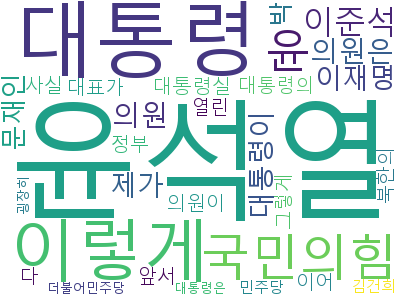

In [360]:
cv = CountVectorizer(tokenizer=nltk.word_tokenize, stop_words=ko_Stopword)

tdm_politics = cv.fit_transform(df_politics.loc[:, 'content'])

word_count_politics = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm_politics.sum(axis=0).flat
})

word_count_politics.set_index('단어')['빈도']
count_dic_politics = word_count_politics.set_index('단어')['빈도'].to_dict()

wc = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf', 
               background_color='white', max_words=30,
               width=400, height=300, random_state = 123)

cloud_politics = wc.generate_from_frequencies(count_dic_politics)
cloud_politics.to_image()

### 2) economic

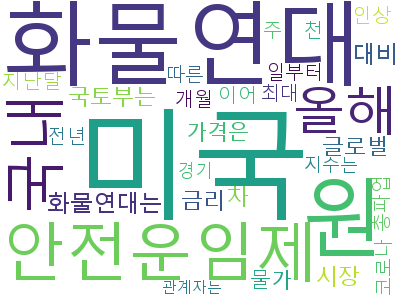

In [361]:
cv = CountVectorizer(tokenizer=nltk.word_tokenize, stop_words=ko_Stopword)

tdm_economic = cv.fit_transform(df_economic.loc[:, 'content'])

word_count_economic = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm_economic.sum(axis=0).flat
})

word_count_economic.set_index('단어')['빈도']
count_dic_economic = word_count_economic.set_index('단어')['빈도'].to_dict()

wc = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf', 
               background_color='white', max_words=30,
               width=400, height=300, random_state = 123)

cloud_economic = wc.generate_from_frequencies(count_dic_economic)
cloud_economic.to_image()

### 3) foreign

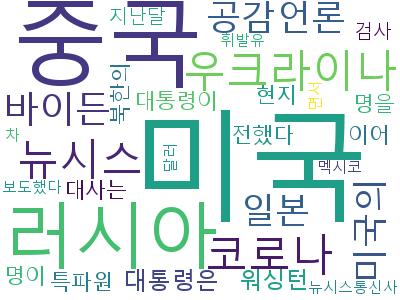

In [362]:
cv = CountVectorizer(tokenizer=nltk.word_tokenize, stop_words=ko_Stopword)

tdm_foreign = cv.fit_transform(df_foreign.loc[:, 'content'])

word_count_foreign = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm_foreign.sum(axis=0).flat
})

word_count_foreign.set_index('단어')['빈도']
count_dic_foreign = word_count_foreign.set_index('단어')['빈도'].to_dict()

wc = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf', 
               background_color='white', max_words=30,
               width=400, height=300, random_state = 123)

cloud_foreign = wc.generate_from_frequencies(count_dic_foreign)
cloud_foreign.to_image()

### 4) culture

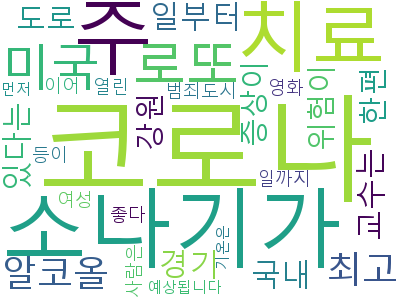

In [363]:
cv = CountVectorizer(tokenizer=nltk.word_tokenize, stop_words=ko_Stopword)

tdm_culture = cv.fit_transform(df_culture.loc[:, 'content'])

word_count_culture = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm_culture.sum(axis=0).flat
})

word_count_culture.set_index('단어')['빈도']
count_dic_culture = word_count_culture.set_index('단어')['빈도'].to_dict()

wc = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf', 
               background_color='white', max_words=30,
               width=400, height=300, random_state = 123)

cloud_culture = wc.generate_from_frequencies(count_dic_culture)
cloud_culture.to_image()

### 5) digital

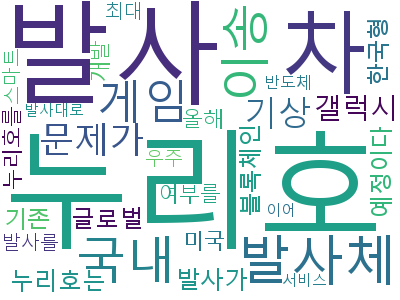

In [364]:
cv = CountVectorizer(tokenizer=nltk.word_tokenize, stop_words=ko_Stopword)

tdm_digital = cv.fit_transform(df_digital.loc[:, 'content'])

word_count_digital = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm_digital.sum(axis=0).flat
})

word_count_digital.set_index('단어')['빈도']
count_dic_digital = word_count_digital.set_index('단어')['빈도'].to_dict()

wc = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf', 
               background_color='white', max_words=30,
               width=400, height=300, random_state = 123)

cloud_digital = wc.generate_from_frequencies(count_dic_digital)
cloud_digital.to_image()

# 5. 전체 기사 TDM

In [365]:
df_politics['label']=0
df_economic['label']=1
df_foreign['label']=2
df_culture['label']=3
df_digital['label']=4

In [368]:
df = pd.concat([df_politics,df_economic,df_foreign,df_culture,df_digital], ignore_index=True)

In [370]:
df.isna().sum()

Unnamed: 0    0
url           0
content       0
label         0
dtype: int64

In [371]:
gc.collect()

19

In [372]:
tdm = cv.fit_transform(df.loc[:, 'content'])

In [373]:
word_count = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

In [374]:
word_count.sort_values('빈도', ascending=False).head()

,단어,빈도
21520,미국,342
44366,윤석열,301
14785,대통령,288
45317,이렇게,285
56533,차,280


In [375]:
word_count.to_csv('data/기사_단어빈도표.csv')

In [376]:
trans = TfidfTransformer()
tdm2 = trans.fit_transform(tdm)
words = cv.get_feature_names()

In [377]:
joblib.dump({'words': words, 'dtm': tdm}, 'tdm.pkl')
joblib.dump({'words': words, 'dtm': tdm2}, 'tdm2.pkl')

['tdm2.pkl']

In [378]:
words[:10]

['ㄱ씨', 'ㄱ씨가', 'ㄱ씨는', 'ㅁ자로', 'ㅅ', 'ㅎㅔㅆ다', '가감', '가거나', '가게', '가게가']

In [379]:
gc.collect()

0

# 6. 감성분석

데이터분할

In [380]:
import joblib
data = joblib.load('tdm2.pkl')
locals().update(data)

In [381]:
df.head()

,Unnamed: 0,url,content,label
0,0,https://v.daum.net/v/20220615235746243,지난달 일 서울 장충동 신라호텔에서 열린 윤석열 대통령 취임 기념 만찬에서 김건...,0
1,1,https://v.daum.net/v/20220615235103213,년 서해에서 북한군 총격으로 사망한 해양수산부 공무원이 타고 있던 어업지도선...,0
2,2,https://v.daum.net/v/20220615235005194,울산 울산시의회는 노후 산업단지 안전 관련 특별법 제정 촉구 건의안을 대통...,0
3,3,https://v.daum.net/v/20220615233421081,권영세 통일부 장관은 기존의 성과를 토대로 삼지 않고는 더 크고 더 평화로운 미래로...,0
4,4,https://v.daum.net/v/20220615233419080,국민의힘 의원들이 한상혁 방송통신위원장을 향해 농지법 의혹 보도에 대한 명확한 입장...,0


In [382]:
from tensorflow.keras.utils import to_categorical
to_categorical(df['label'])

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [383]:
x = dtm
y = to_categorical(df['label']) # 시리즈여서 넘파이 어레이 형식으로 바꿔줘야함(시리즈는 머신러닝에 못넣음)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1984)

In [384]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(5, activation='softmax')) 
                               # kernel_regularizer=tf.keras.regularizers.I2(0.001)))
# Dense = 선형모형
# 그냥 1만 넣어주면 선형모형, 뒤에 저거 넣어주면 로지스틱 회귀분석이 됨

In [385]:
dtm

<1367x69561 sparse matrix of type '<class 'numpy.float64'>'
	with 178254 stored elements in Compressed Sparse Row format>

In [386]:
pd.DataFrame(y)

,0,1,2,3,4
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
1362,0.0,0.0,0.0,0.0,1.0
1363,0.0,0.0,0.0,0.0,1.0
1364,0.0,0.0,0.0,0.0,1.0
1365,0.0,0.0,0.0,0.0,1.0


------------------  
https://wikidocs.net/22933

In [387]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

--------------------

In [388]:
# optimizer = 어떻게 학습시킬 것인가, adam = 변형된 경사하강법
# loss = 손실함수, binary~ = 교차엔트로피, matrics = 평가지표(예측한 값을 확인하기 위해 설정)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

https://www.python2.net/questions-841133.htm

In [389]:
model.fit(x_train.A,y_train,epochs=5, batch_size=20, callbacks=[es,mc])#,validation_data=0.1)

Epoch 1/5
55/55 [==============================] - 1s 7ms/step - loss: 1.5822 - accuracy: 0.5380
Epoch 2/5
55/55 [==============================] - 0s 7ms/step - loss: 1.4724 - accuracy: 0.8298
Epoch 3/5
55/55 [==============================] - 0s 7ms/step - loss: 1.3690 - accuracy: 0.8435
Epoch 4/5
55/55 [==============================] - 0s 7ms/step - loss: 1.2732 - accuracy: 0.8500
Epoch 5/5
55/55 [==============================] - 0s 7ms/step - loss: 1.1856 - accuracy: 0.8536


In [390]:
model.evaluate(x_test.A, y_test)

9/9 [==============================] - 0s 8ms/step - loss: 1.3495 - accuracy: 0.6423


[1.3494668006896973, 0.6423357725143433]

In [391]:
model.save('f_tdm2.krs')

INFO:tensorflow:Assets written to: f_tdm2.krs\assets


# 7. 가중치 분석

In [392]:
model = tf.keras.models.load_model('f_tdm2.krs')
w, b = model.weights

In [393]:
pd.DataFrame(w.numpy())

,0,1,2,3,4
0,0.031841,-0.028790,-0.030133,-0.026847,-0.030553
1,0.025665,-0.037044,-0.032002,-0.029735,-0.036823
2,0.030446,-0.040278,-0.033572,-0.027005,-0.023414
3,-0.009257,-0.001078,0.005824,-0.007469,-0.005428
4,0.036715,-0.024899,-0.034340,-0.036247,-0.031987
...,...,...,...,...,...
69556,-0.023049,-0.041159,-0.039327,0.024338,-0.040024
69557,-0.038626,0.041029,-0.023383,-0.040978,-0.025826
69558,-0.040554,-0.046870,-0.034161,0.047767,-0.036542
69559,-0.025680,-0.040032,-0.032069,0.026691,-0.030620


In [394]:
w.numpy()[:,0]

array([ 0.03184088,  0.02566502,  0.03044578, ..., -0.04055436,
       -0.02567997,  0.0071517 ], dtype=float32)

In [395]:
import pandas as pd
word_sent = pd.DataFrame({'토큰': data['words'], '가중치_0': w.numpy()[:,0],
                          '가중치_1': w.numpy()[:,1], '가중치_2': w.numpy()[:,2],
                         '가중치_3': w.numpy()[:,3], '가중치_4': w.numpy()[:,4]})

In [396]:
word_sent.sort_values('가중치_0')[['토큰','가중치_0']].sort_values('가중치_0', ascending = False).head(10) # 정치 기사

,토큰,가중치_0
44366,윤석열,0.197258
6912,국민의힘,0.168744
40320,열린,0.166397
14785,대통령,0.165915
47906,입장을,0.158061
44833,의원,0.156356
37676,앞서,0.151696
26666,북한의,0.151629
44875,의원은,0.151203
14838,대통령이,0.150693


In [397]:
word_sent.sort_values('가중치_1')[['토큰','가중치_1']].sort_values('가중치_1', ascending = False).head(10) # 경제 기사

,토큰,가중치_1
43736,유가,0.135520
14405,대비,0.134349
65233,한국경제,0.133098
67941,화물연대는,0.128151
65235,한국경제티브이,0.125723
21520,미국,0.125371
7183,국토교통부와,0.123501
40081,연방준비제도,0.122411
46678,인상,0.120966
17184,따른,0.120768


In [398]:
word_sent.sort_values('가중치_2')[['토큰','가중치_2']].sort_values('가중치_2', ascending = False).head(10) # 국제 기사

,토큰,가중치_2
42965,워싱턴,0.090781
21543,미국의,0.090146
17666,러시아,0.088777
62320,특파원,0.088717
67288,현지,0.085917
54161,중국,0.079556
25183,보도했다,0.079235
8934,기사내용,0.079021
42182,요약,0.075201
21540,미국으로,0.074935


In [399]:
word_sent.sort_values('가중치_3')[['토큰','가중치_3']].sort_values('가중치_3', ascending = False).head(10) # 문화 기사

,토큰,가중치_3
67040,헬스조선,0.140308
1292,강원,0.134253
58275,최고,0.133443
32200,소나기가,0.128175
15342,도로,0.124150
8971,기상캐스터,0.117041
60844,클립아트코리아,0.116978
36792,아침,0.116332
39829,연구,0.112512
4655,곳곳에,0.112024


In [400]:
word_sent.sort_values('가중치_4')[['토큰','가중치_4']].sort_values('가중치_4', ascending = False).head(10) # IT 기사

,토큰,가중치_4
12697,누리호,0.165815
23097,발사,0.164112
23173,발사체,0.146999
4530,고흥,0.146197
65449,한국항공우주연구원,0.143313
23098,발사가,0.141991
12703,누리호를,0.141487
52653,조립동에서,0.138250
8955,기상,0.137137
12700,누리호는,0.136980


# 8. 주제분석

In [401]:
gc.collect()

3133

In [402]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [403]:
pyLDAvis.enable_notebook()

In [404]:
token_re = re.compile(r'\b\w{2,}\b', re.UNICODE)
def tokenizer(text):
    text = text.lower()
    words = []
    for word in token_re.findall(text):
        if word not in ko_Stopword:
            words.append(word)
    return words

docs = []
for text in df.content:
    doc = tokenizer(text)
    docs.append(doc)

dic = Dictionary(docs)

corpus = []
for doc in docs:
    bow = dic.doc2bow(doc)
    corpus.append(bow)

dic.filter_extremes(no_below=10, no_above=0.7)

corpus = []
for doc in docs:
    bow = dic.doc2bow(doc)
    corpus.append(bow)

In [405]:
gc.collect()

0

In [406]:
train_corpus, valid_corpus = train_test_split(corpus, test_size=0.1, random_state=0)

In [413]:
model = LdaModel(
    corpus=train_corpus,
    id2word=dic,
    num_topics=5,
    random_state=0)

In [414]:
old_loss = -numpy.inf
loss = model.log_perplexity(valid_corpus)
loss

-9.968322392405167

In [415]:
while loss > old_loss + 0.1:
    model.update(train_corpus)
    old_loss = loss
    loss = model.log_perplexity(valid_corpus)
    print(loss)

-10.041236811399493


In [416]:
model.save('lda-model')

In [417]:
p = pyLDAvis.gensim.prepare(model, corpus, dic, sort_topics=False)
pyLDAvis.display(p)